In [1]:
import numpy as np
import torch

%run maze_generation.ipynb import *

C:\Users\db2admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-1, 1, 27, 27)

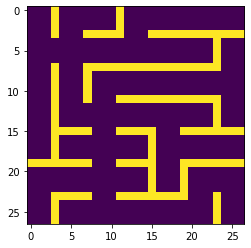

In [2]:
np.random.seed(5)
maze = generate_wide_maze(7,3)
maze2 = generate_wide_maze(7,3)

plt.imshow(maze)
MAZE_SHAPE = maze.shape

def get_maze_shape(maze, n=None, channels=True):
    result = []
    if n is None:
        result.append(-1)
    elif n > 0:
        result.append(n)
    if channels == True:
        result.append(1)
    result.append(maze.shape[0])
    result.append(maze.shape[0])
    return tuple(result)
get_maze_shape(maze)

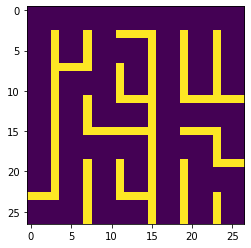

In [3]:
plt.imshow(maze2)

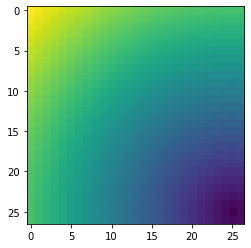

In [4]:
# We have a static start and end goal, so our H map will always look as follows:
def get_h_map(maze):
    h = torch.zeros(maze.shape)
    for i in range(len(h)):
        for j in range(len(h)):
            h[i][j] = np.linalg.norm(np.asarray([i,j]) - np.asarray([len(maze) - 2, len(maze) - 2]))
    return h / torch.max(h)

h = get_h_map(maze)
plt.imshow(h)
h = h.reshape(-1,1,maze.shape[0], maze.shape[0])

# Node Selection

### A differentiable operation designed to select the lowest cost node.
$V^* = I_{max}
(\frac{exp(-(G+H)/\tau) \odot O}{\langle exp(-G+H)/\tau),O\rangle}) $

    input:
        o (1d Tensor): 1d Tensor indicating status of node within the openset
        g (1d Tensor): 1d Tensor indicating the g-score associated to a node
        h (1d Tensor): 1d Tensor indicating heuristic cost of reaching the end node from each point
        
    output:
        (int): index of the lowest cost node in the flattened tensor

In [5]:
"""
NODE SELECTION: Single maps
"""
def node_selection(o,g,h):
    tau = np.sqrt(len(o))
    numerator = (torch.exp(-(g.flatten() + h.flatten())/tau) * o.float().flatten())
    denomenator = (torch.exp(-(g.flatten() + h.flatten())/tau) @ o.float().T.flatten())
    v_star = numerator/denomenator
    return v_star.flatten().argmax()

# Select the lowest g/h score node to 
np.random.seed(1)
o = torch.Tensor(np.random.randint(0,2,len(maze)**2).reshape((len(maze),len(maze)))).float()
g = torch.Tensor(np.random.rand(len(maze)**2).reshape((len(maze),len(maze))))
h_ = torch.Tensor(np.random.rand(len(maze)**2).reshape((len(maze),len(maze))))
o.flatten()[27] = 1
g.flatten()[27] = 0
h_.flatten()[27] = 0
v_star = node_selection(o,g,h_)
v_star, g.dtype

(tensor(27), torch.float32)

# Node Expansion
### Expand the search to include the nodes that neighbour the selected node

In [6]:
def node_expansion(v_star, cells, o, c):
    # Create the kernel
    K = torch.Tensor([[[[1,1,1],[1,0,1],[1,1,1]]]])
    
    # Get the indicator vector from the 
    v_star_I = torch.zeros(cells.shape, dtype=torch.float32)
    v_star_I.flatten()[v_star] = 1

    # Perform the convolution
    v_nbr = torch.nn.functional.conv2d(v_star_I.reshape((1,1,len(maze),len(maze))), K, padding=1)
    
    # Exclude walls, and elements in the closed set:
    v_nbr = v_nbr * (1 - cells) * (1 - o.detach()) * (1 - c)
    v_bar_nbr = v_nbr * (1 - cells) * (o.detach()) * (1 - c)
    return v_nbr, v_bar_nbr

v_star_I = torch.zeros(maze.shape, dtype=torch.float32)
v_star_I.flatten()[v_star] = 1
    
o = torch.zeros(maze.shape, dtype=torch.float32)    
c = torch.zeros(maze.shape, dtype=torch.float32)
    
v_nbr, v_bar_nbr = node_expansion(v_star, maze, o, c)


In [7]:
def get_v_star_I(v_star, square=False, channels=False):
    if v_star.size() == torch.Size([]):
        vi = torch.zeros(maze.size)
        vi.flatten()[v_star] = 1
        return vi
        
    vi = torch.stack([torch.zeros(maze.size) for m in v_star])
    for vs in enumerate(v_star):
        vi[vs[0], vs[1]] = 1
    if square==True:
        vi = vi.reshape(get_maze_shape(maze,channels=channels))
    return vi

v_star_I


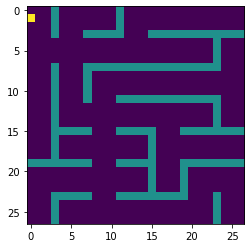

In [8]:
print("v_star_I")
plt.imshow(maze + v_star_I.numpy()*2)

node expansion


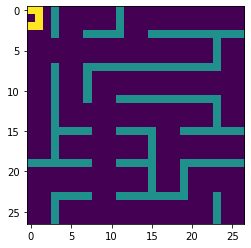

In [9]:
print("node expansion")
plt.imshow(maze + v_nbr[0].numpy().reshape((maze.shape[0],maze.shape[0]))*2)

# Updating Guidance Costs

Updated guidance costs


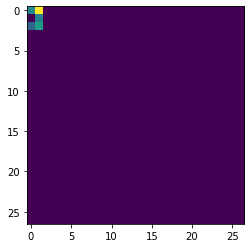

In [10]:
def update_guidance_costs(v_star, 
                          v_nbr, 
                          v_bar_nbr, 
                          phi, 
                          g):
    v_star_I = torch.zeros(g.shape, dtype=torch.float32)
    v_star_I.flatten()[v_star] = 1
    
    # Temporary; needs to be in x,x,r,c for batching
    v_nbr = v_nbr.reshape(g.shape)
    v_bar_nbr = v_bar_nbr.reshape(g.shape)
    try:
        gp = g @ v_star_I + phi
    except:
        print(g.shape, v_star_I.T.shape, phi.shape)
        raise Exception()
        
    g = gp * v_nbr.detach() + torch.minimum(g, gp) * v_bar_nbr.detach()
    g = g + g * (torch.ones(g.shape) - v_nbr.detach() - v_bar_nbr.detach())
    return g.float()

print("Updated guidance costs")
phi = np.random.rand(len(g.flatten())).reshape(g.shape)
phi = torch.Tensor(phi)
new_g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)
plt.imshow(new_g.detach().squeeze())


# Minibatch Training

In [11]:
def get_verification_flag(v_star, maze):
    goal_index = len(maze) ** 2 - len(maze) - 1
    if v_star.item() == goal_index:
        return 1
    else:
        return 0

def vector_to_I(v, maze):
    v_I = torch.zeros(maze.shape)
    v_I.flatten()[v] = 1
    return v_I

In [12]:
vg = torch.zeros(maze.shape)
vg[-2,-2] = 1
vg @ v_star_I.reshape(maze.shape).T

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

# Backtracking

In [13]:
def backtrack(parents):
    path = torch.zeros(maze.shape)
    parent = parents[-2,-2]
    while parent != 0:
        parent = parent.int().item()
        path.flatten()[parent] = 1
        parent = parents.flatten()[parent]
    return path

# Network

In [14]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
                torch.nn.Conv2d(1, 8, 3, stride=2, padding=1),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(16, 32, 3, stride=2, padding=0),
                torch.nn.ReLU(True)
            )
        self.decoder = torch.nn.Sequential(
                torch.nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                torch.nn.ReLU(True),
                torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                torch.nn.ReLU(True),
                torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=0)
    )
    
    def forward(self, x):
        x = x.reshape((-1,1,MAZE_SHAPE[0], MAZE_SHAPE[0]))
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
net = Network()

# Putting it together

In [15]:
seed = 7

177


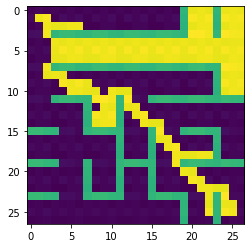

In [17]:
# compute phi from the encoder
np.random.seed(seed)
maze = generate_wide_maze(7,3)
phi = net(torch.Tensor(maze))

# initialize the openset, closed set, guidance map, parents
o = torch.zeros(maze.shape, dtype=torch.float32)
c = torch.zeros(maze.shape, dtype=torch.float32)
g = torch.zeros(maze.shape, dtype=torch.float32)
parents = torch.zeros(maze.shape)

o[1,1] = 1

for i in range(2000):
    # Perform node selection
    v_star = node_selection(o,g,h)

    # Get verification flags (computing n)
    n = get_verification_flag(v_star, maze)

    # Update open-set / closed-set
    v_star_I = get_v_star_I(v_star, square=True, channels=True)
    o = o - (1-n)*v_star_I.reshape(maze.shape).float()
    c = c + (1-n)*v_star_I.reshape(maze.shape).float()

    # Expand the node neighbourhood, update open-set
    v_nbr, v_bar_nbr = node_expansion(v_star, maze, o, c)
    o = o + v_nbr

    # Update g
    g = update_guidance_costs(v_star, v_nbr, v_bar_nbr, phi, g)

    # Update parents
    for ix in np.nonzero(v_nbr.reshape(maze.shape)):
        parents[ix[0]][ix[1]] = v_star
    
    if n == True:
        break
print(i)
plt.imshow(c.squeeze().numpy()*3 + maze*2 + phi.squeeze().detach().numpy()*2)
seed += 1

In [ ]:
plt.imshow(backtrack(parents).detach().numpy()*2 + maze)

In [ ]:
# Examining the closed sets
i = 0
plt.imshow(c.squeeze().numpy()[i]*2 + maze[i].squeeze().numpy())